Demo #6: Parameters tuning  \
- For model 
- For SKF (Switching Kalman Filter)

Import libraries

In [139]:
import sys
import os
from pathlib import Path
# project_root = Path.cwd().parent
# sys.path.append(project_root)
project_root = Path("/Users/vuongdai/GitHub/canari")  
sys.path.append(str(project_root))  

import ray 
ray.shutdown() 
ray.init(runtime_env={"working_dir": "/Users/vuongdai/GitHub/canari"})
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from examples import DataProcess
from pytagi import Normalizer
import pytagi.metric as metric
import copy

2025-03-25 16:32:23,790	INFO worker.py:1841 -- Started a local Ray instance.
2025-03-25 16:32:24,879	INFO packaging.py:574 -- Creating a file package for local module '/Users/vuongdai/GitHub/canari'.
2025-03-25 16:32:24,902	WARNING packaging.py:416 -- File /Users/vuongdai/GitHub/canari/.git/objects/57/117f0488cb76d05e1639784f731008c7d9828d is very large (12.33MiB). Consider adding this file to the 'excludes' list to skip uploading it: `ray.init(..., runtime_env={'excludes': ['/Users/vuongdai/GitHub/canari/.git/objects/57/117f0488cb76d05e1639784f731008c7d9828d']})`
2025-03-25 16:32:24,923	WARNING packaging.py:416 -- File /Users/vuongdai/GitHub/canari/.git/objects/6a/0aee702bf6411c51b2c1646959988e653f4c3e is very large (11.79MiB). Consider adding this file to the 'excludes' list to skip uploading it: `ray.init(..., runtime_env={'excludes': ['/Users/vuongdai/GitHub/canari/.git/objects/6a/0aee702bf6411c51b2c1646959988e653f4c3e']})`
2025-03-25 16:32:24,943	WARNING packaging.py:416 -- File /

(objective pid=33636) [2025-03-25 20:32:42 UTC] ERROR /Users/runner/work/cuTAGI/cuTAGI/src/sequential.cpp:244 - Input size mismatch: 29 vs 17
(objective pid=33667) [2025-03-25 20:32:49 UTC] ERROR /Users/runner/work/cuTAGI/cuTAGI/src/sequential.cpp:244 - Input size mismatch: 34 vs 22 [repeated 16x across cluster]
(objective pid=33729) [2025-03-25 20:32:56 UTC] ERROR /Users/runner/work/cuTAGI/cuTAGI/src/sequential.cpp:244 - Input size mismatch: 49 vs 37 [repeated 16x across cluster]
(objective pid=33764) [2025-03-25 20:33:03 UTC] ERROR /Users/runner/work/cuTAGI/cuTAGI/src/sequential.cpp:244 - Input size mismatch: 29 vs 17 [repeated 16x across cluster]


Import components

In [140]:
from src import (
    LocalTrend,
    LocalAcceleration,
    LstmNetwork,
    WhiteNoise,
    Model,
    ModelOptimizer,
    SKF,
    SKFOptimizer,
    plot_data,
    plot_prediction,
    plot_skf_states,
    plot_states,
)

Read data

In [141]:
data_file = "/Users/vuongdai/GitHub/canari/data/benchmark_data/test_4_data.csv"
df = pd.read_csv(data_file, skiprows=1, delimiter=",", header=None)
time = pd.to_datetime(df.iloc[:, 0])
df = df.iloc[:, 1:]
df.index = time
df.index.name = "time"
df.columns = ["crack opening", "water_level", "temp_min", "temp_max"]
lags = [0, 4, 4, 4]
df_lag = DataProcess.add_lagged_columns(df, lags)

Data preprocess

In [ ]:
output_col = [0]
data_processor = DataProcess(
    data=df_lag,
    time_covariates=["week_of_year"],
    train_split=0.23,
    validation_split=0.07,
    output_col=output_col,
)
train_data, validation_data, test_data, all_data = data_processor.get_splits()
(
    data_processor.train_data,
    data_processor.validation_data,
    data_processor.test_data,
    data_processor.all_data,
) = data_processor.get_splits()

Step #1: Tune parameters for model

1A. Define model with parameters

In [143]:
def initialize_model(param):
    return Model(
        LocalTrend(),
        LstmNetwork(
            look_back_len=param["look_back_len"],
            num_features=17,
            num_layer=1,
            num_hidden_unit=50,
            device="cpu",
            manual_seed=1,
        ),
        WhiteNoise(std_error=param["sigma_v"]),
    )

1B. Parameter search space

In [144]:
param = {
    "look_back_len": [12, 52],
    "sigma_v": [1e-3, 2e-1],
}

1C. Training procedure

In [145]:
def training(model, data_processor, num_epoch: int = 50):
    """
    Training procedure
    """

    model.auto_initialize_baseline_states(data_processor.train_data["y"][0 : 52 * 3])
    states_optim = None
    mu_validation_preds_optim = None
    std_validation_preds_optim = None

    for epoch in range(num_epoch):
        mu_validation_preds, std_validation_preds, states = model.lstm_train(
            train_data=data_processor.train_data,
            validation_data=data_processor.validation_data,
        )

        mu_validation_preds_unnorm = Normalizer.unstandardize(
            mu_validation_preds,
            data_processor.norm_const_mean[data_processor.output_col],
            data_processor.norm_const_std[data_processor.output_col],
        )

        std_validation_preds_unnorm = Normalizer.unstandardize_std(
            std_validation_preds,
            data_processor.norm_const_std[data_processor.output_col],
        )

        validation_obs = data_processor.get_data("validation").flatten()
        validation_log_lik = metric.log_likelihood(
            prediction=mu_validation_preds_unnorm,
            observation=validation_obs,
            std=std_validation_preds_unnorm,
        )

        model.early_stopping(evaluate_metric=-validation_log_lik, mode="min")

        if epoch == model.optimal_epoch:
            mu_validation_preds_optim = mu_validation_preds.copy()
            std_validation_preds_optim = std_validation_preds.copy()
            states_optim = copy.copy(states)
        if model.stop_training:
            break

    return (
        model,
        states_optim,
        mu_validation_preds_optim,
        std_validation_preds_optim,
    )

1. Model optimizer

In [146]:
model_optimizer = ModelOptimizer(
    initialize_model=initialize_model,
    train=training,
    param_space=param,
    data_processor=data_processor,
    num_optimization_trial=50,
)
model_optimizer.optimize()
# Get optimal model
model_optim = model_optimizer.get_best_model()

2025-03-25 16:32:42,519	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_4bc74_00000
Traceback (most recent call last):
  File "/opt/miniconda3/envs/canari/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/opt/miniconda3/envs/canari/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/opt/miniconda3/envs/canari/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/opt/miniconda3/envs/canari/lib/python3.10/site-packages/ray/_private/worker.py", line 2772, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "/opt/miniconda3/envs/canari/lib/python3.10/site-packages/ray/_private/worker.py", line 919, in get_objects
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(Runt

AttributeError: 'NoneType' object has no attribute 'trial_id'

Train the optimal model again

In [ ]:
model_optim, states_optim, mu_validation_preds, std_validation_preds = training(
    model=model_optim, data_processor=data_processor
)

Save optimal model for SKF analysis later

In [ ]:
model_optim_dict = model_optim.get_dict()

Step #2: Tune parameters for SKF

2A. Define SKF model with parameters

In [ ]:
def initialize_skf(skf_param, model_param: dict):
    norm_model = Model.load_dict(model_param)
    abnorm_model = Model(
        LocalAcceleration(),
        LstmNetwork(),
        WhiteNoise(),
    )
    skf = SKF(
        norm_model=norm_model,
        abnorm_model=abnorm_model,
        std_transition_error=skf_param["std_transition_error"],
        norm_to_abnorm_prob=skf_param["norm_to_abnorm_prob"],
        abnorm_to_norm_prob=1e-1,
        norm_model_prior_prob=0.99,
    )
    return skf

2B. Parameters space

In [ ]:
slope_upper_bound = 5e-2
slope_lower_bound = 1e-3
grid_search = False
if grid_search:
    skf_param = {
        "std_transition_error": [1e-6, 1e-5, 1e-4, 1e-3],
        "norm_to_abnorm_prob": [1e-6, 1e-5, 1e-4, 1e-3],
        "slope": [0.002, 0.004, 0.006, 0.008, 0.01, 0.03, 0.05, 0.07, 0.09],
    }
else:
    skf_param = {
        "std_transition_error": [1e-6, 1e-3],
        "norm_to_abnorm_prob": [1e-6, 1e-3],
        "slope": [slope_lower_bound, slope_upper_bound],
    }

Detect synthetic anomalies

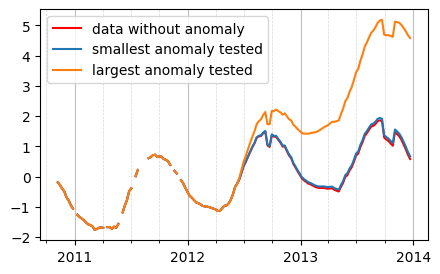

In [ ]:
synthetic_anomaly_data = DataProcess.add_synthetic_anomaly(
    data_processor.train_data,
    num_samples=1,
    slope=[slope_lower_bound, slope_upper_bound],
)
fig, ax = plt.subplots(figsize=(5,3))
plot_data(
    data_processor=data_processor,
    normalization=True,
    plot_validation_data=False,
    plot_test_data=False,
    plot_column=output_col,
    train_label="data without anomaly",
)

train_time = data_processor.get_time("train")
for ts in synthetic_anomaly_data:
    plt.plot(train_time, ts["y"])
plt.legend(
    [
        "data without anomaly",
        # "",
        "smallest anomaly tested",
        "largest anomaly tested",
    ]
)

2. SKF optimizer

In [ ]:
skf_optimizer = SKFOptimizer(
    initialize_skf=initialize_skf,
    model_param=model_optim_dict,
    param_space=skf_param,
    data=data_processor.train_data,
    num_synthetic_anomaly=50,
    num_optimization_trial=100,
    grid_search=grid_search,
)
skf_optimizer.optimize()
# Get optimal model
skf_optim = skf_optimizer.get_best_model()

#   1/100 - Metric: 2.020 - Detection rate: 0.00 - False rate: 1.00 - False alarm in train: Yes - Parameter: {'std_transition_error': 0.000941451083071621, 'norm_to_abnorm_prob': 0.00033856396276503746, 'slope': 0.0039511704999217745}
#   2/100 - Metric: 2.040 - Detection rate: 0.00 - False rate: 1.00 - False alarm in train: Yes - Parameter: {'std_transition_error': 0.0008424975090163865, 'norm_to_abnorm_prob': 9.196694041057757e-05, 'slope': 0.007911576739964067}
#   3/100 - Metric: 2.099 - Detection rate: 0.92 - False rate: 0.16 - False alarm in train: Yes - Parameter: {'std_transition_error': 2.2026734762726176e-05, 'norm_to_abnorm_prob': 8.542217474977068e-05, 'slope': 0.019871929584423978}
#   4/100 - Metric: 2.166 - Detection rate: 0.86 - False rate: 1.00 - False alarm in train: Yes - Parameter: {'std_transition_error': 0.0009113238761972686, 'norm_to_abnorm_prob': 1.0490377552976856e-05, 'slope': 0.03327763737576054}
#   5/100 - Metric: 0.526 - Detection rate: 0.52 - False rate:

2025-03-25 16:08:32,267	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/Users/vuongdai/ray_results/SKF_optimizer' in 0.0333s.


#  99/100 - Metric: 2.016 - Detection rate: 0.00 - False rate: 0.00 - False alarm in train: No - Parameter: {'std_transition_error': 2.150402224649414e-06, 'norm_to_abnorm_prob': 1.903672268976273e-05, 'slope': 0.003257948906264204}
# 100/100 - Metric: 2.150 - Detection rate: 0.00 - False rate: 0.00 - False alarm in train: No - Parameter: {'std_transition_error': 1.4809904500152391e-06, 'norm_to_abnorm_prob': 0.0003139904268703665, 'slope': 0.03007481565121163}
-----
Optimal parameters at trial #5: {'std_transition_error': 1.306386140536608e-05, 'norm_to_abnorm_prob': 3.7867454935814765e-06, 'slope': 0.0012967687900420544}
-----


Anomaly detection

In [ ]:
filter_marginal_abnorm_prob, states = skf_optim.filter(data=data_processor.all_data)
smooth_marginal_abnorm_prob, states = skf_optim.smoother(
    data=data_processor.all_data
)

Plot results

Text(0.5, 1, 'SKF hidden states')

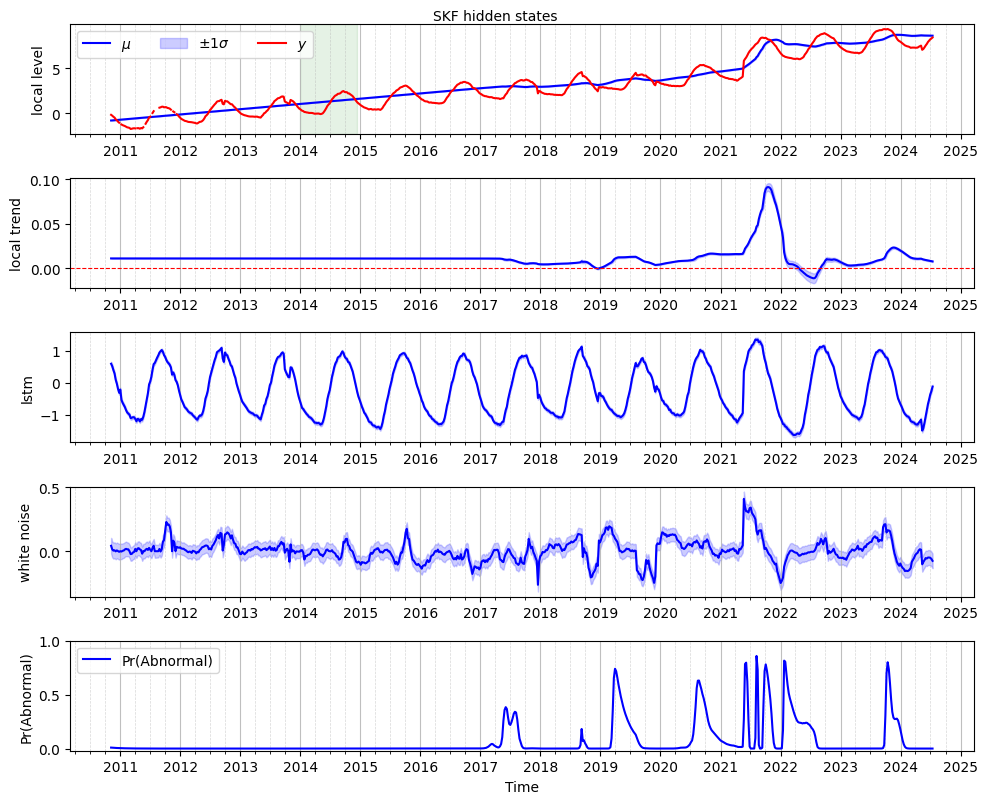

In [ ]:
fig, ax = plot_skf_states(
    data_processor=data_processor,
    states=states,
    states_to_plot=["local level", "local trend", "lstm", "white noise"],
    model_prob=filter_marginal_abnorm_prob,
    color="b",
    legend_location="upper left",
)
fig.suptitle("SKF hidden states", fontsize=10, y=1)